In [1]:
import torch
from gensim.models import Word2Vec
import torch.nn as nn
import cv2
from matplotlib.pyplot import imshow
import numpy as np

In [2]:
w2v = Word2Vec.load("bare_minimum")
w2v.wv["bear"].shape

(16,)

In [3]:
w2v.wv.__len__()

10

In [13]:
bear = cv2.imread("bear.jpg")
bear = cv2.resize(bear,(128,128))
hospital = cv2.imread("hos.png")
hospital = cv2.resize(hospital,(128,128))
strike = cv2.imread("strike.jpg")
strike = cv2.resize(strike,(128,128))
imgs = np.array([(i.reshape(1,3,128,128) / 256).astype(np.float32) for i in [bear, hospital, strike]])

In [118]:
# MAKE SURE YOU ADD ANY LAYERS TO THE FORWARD FUNCTION
# THE GOAL IS COLOR
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.dense1 = nn.Linear(16, 256, bias=False)
        # Try upscaling more linearly, but make sure it is a square number that can be upscaled by 2 to 128
        
        self.upsample1 = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv_up1 = nn.Conv2d(1, 8, 3, padding=1, bias=False)

        self.upsample2 = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv_up2 = nn.Conv2d(8, 16, 3, padding=1, bias=False)

        self.upsample3 = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv_up3 = nn.Conv2d(16, 3, 3, padding=1, bias=False)

        self.refine = nn.Conv2d(4, 3, 3, padding=1, bias=False)  # Extra layer to improve color
        # Try modifying the in/out channels and kernel sizes here. 
        # Can also add normal Conv layers between these, just make sure padding = kernel_size // 2
        
        self.mesh = nn.Conv2d(4, 3, 3, padding=1, bias=False)
        # Try adding additional layers here, since this is the place where
        # the current sentence image is merged with the word
        self.merge1 = nn.Conv2d(4, 8, 3, padding=1, bias=False)  # Adjust the input channels if needed
        self.merge2 = nn.Conv2d(8, 3, 3, padding=1, bias=False)  # Adjust the input channels if needed
        
        self.batch_norm = nn.BatchNorm2d(3)
        
    def forward(self, word_vec, simage):
        
        x = self.dense1(word_vec)
        x = nn.functional.relu(x)
        
        x = x.reshape((-1,1,16,16))
        
        x = self.upsample1(x)
        x = nn.functional.relu(x)
        x = self.upsample2(x)
        x = nn.functional.relu(x)
        x = self.upsample3(x)
        
        x = nn.functional.leaky_relu(x, negative_slope=0.02) # <- This activation function should result in something image-like, relu isn't great
        
        # Make modifications here too
        
        x = torch.concat((simage, x), dim=1)
        x = self.merge1(x)
        x = nn.functional.leaky_relu(x, negative_slope=0.02)
        x = self.merge2(x)
        x = self.batch_norm(x)
        return nn.functional.tanh(x)
    
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 3, 3, padding=1, bias=True)
        self.conv2 = nn.Conv2d(3, 3, 3, padding=1, bias=True)
        self.conv3 = nn.Conv2d(3, 3, 3, padding=1, bias=True)
        
        self.pool1 = nn.MaxPool2d(2)
        self.conv4 = nn.Conv2d(3, 3, 3, padding=1, bias=False)
        self.pool2 = nn.MaxPool2d(2)
        self.conv5 = nn.Conv2d(3,6,3,padding=1, bias=False)
        self.pool3 = nn.MaxPool2d(2)
        self.conv6 = nn.Conv2d(6,1,3,padding=1, bias=False)
        
        
        self.flatten = nn.Flatten()
        self.classify1 = nn.Linear(266,128, bias=False)
        self.classify2 = nn.Linear(128,64, bias=False)
        self.classify3 = nn.Linear(64, 10, bias=False)
        
        self.next1 = nn.Conv2d(3,16,3,padding=1, bias=False)
        self.next2 = nn.Conv2d(16,16,3,padding=1, bias=False)
        self.next3 = nn.Conv2d(16, 3, 1, bias=False)
        
        
    def forward(self, input, context):
        
        x = self.conv1(input)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.conv3(x)
        x = nn.functional.relu(x)
        
        c = self.pool1(x)
        c = self.conv4(c)
        c = nn.functional.relu(c)
        c = self.pool2(c)
        c = self.conv5(c)
        c = nn.functional.relu(c)
        c = self.pool3(c)
        c = self.conv6(c)
        c = nn.functional.relu(c)

        c = self.flatten(c)
        c = torch.concat((c, context), dim=1)
        c = self.classify1(c)
        c = nn.functional.relu(c)
        c = self.classify2(c)
        c = nn.functional.relu(c)
        c = self.classify3(c)
        
        n = self.next1(x)
        n = nn.functional.relu(n)
        n = self.next2(n)
        n = nn.functional.relu(n)
        n = self.next3(n)
        n = nn.functional.sigmoid(n)
        
        return c, n

In [119]:
torch.manual_seed(42)
enc = Encoder()
dec = Decoder()

In [120]:
a = enc(torch.from_numpy(w2v.wv['bear']), torch.zeros(1,3,128,128))
dec(a, torch.zeros(1,10))

(tensor([[-7.0695e-05,  4.4634e-04, -1.2892e-04,  3.7124e-05, -8.3146e-05,
           2.8743e-04,  2.2902e-04,  1.0379e-04, -2.0347e-04,  3.8550e-05]],
        grad_fn=<MmBackward0>),
 tensor([[[[0.5012, 0.5008, 0.5018,  ..., 0.5019, 0.5018, 0.5009],
           [0.5020, 0.5025, 0.5024,  ..., 0.5025, 0.5023, 0.5015],
           [0.5033, 0.5040, 0.5025,  ..., 0.5030, 0.5023, 0.5015],
           ...,
           [0.5021, 0.5021, 0.5026,  ..., 0.5031, 0.5024, 0.5012],
           [0.5020, 0.5023, 0.5023,  ..., 0.5028, 0.5022, 0.5010],
           [0.5015, 0.5020, 0.5013,  ..., 0.5015, 0.5012, 0.5006]],
 
          [[0.5002, 0.5004, 0.5008,  ..., 0.5005, 0.5004, 0.5008],
           [0.5000, 0.5011, 0.5016,  ..., 0.5012, 0.5009, 0.5009],
           [0.4997, 0.5009, 0.5016,  ..., 0.5010, 0.5007, 0.5007],
           ...,
           [0.5002, 0.5010, 0.5021,  ..., 0.5011, 0.5007, 0.5005],
           [0.5004, 0.5009, 0.5021,  ..., 0.5013, 0.5009, 0.5004],
           [0.5004, 0.5008, 0.5015,  ..., 0.

In [121]:
sentences = [["the", "bear", "is", "eating", "honey"],
             ["where", "is", "the", "hospital"],
             ["students", "are", "striking"]]
images = torch.tensor(imgs)

In [122]:
# define optim
crit_words = nn.CrossEntropyLoss()
crit_image = nn.MSELoss()

s = nn.ModuleList([enc,dec])

optim = torch.optim.Adam(s.parameters())

In [123]:
## Training loop
epochs = 500
for epoch in range(epochs):
    sents = []
    for img,sent in zip(images,sentences):
        optim.zero_grad()
        canvas = torch.zeros(1,3,128,128)
        for w in sent:
            canvas = enc(torch.from_numpy(w2v.wv[w]).float(), canvas)
        # Try modifying weights or training scheme
        loss = crit_image(img, canvas)
        pic = canvas.clone()
        context = torch.zeros(1,10)
        outs = []
        for w in sent:
            word, canvas = dec(canvas, context)
            context = word
            loss = loss + crit_words(word, torch.tensor([w2v.wv.key_to_index[w]]))
            outs.append(word)
        loss.backward()
        optim.step()
        sents.append(outs)

In [124]:
[[w2v.wv.index_to_key[w.argmax()] for w in sen] for sen in sents]

[['the', 'bear', 'is', 'eating', 'honey'],
 ['where', 'is', 'the', 'hospital'],
 ['students', 'are', 'striking']]

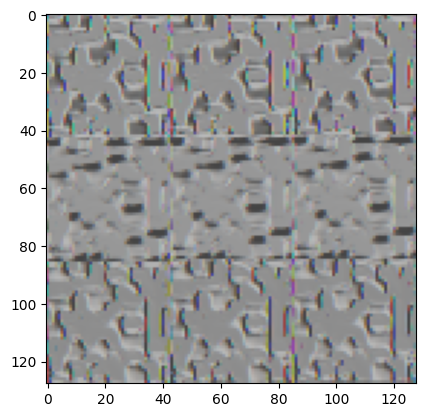

In [125]:
imshow(nn.functional.sigmoid(pic).detach().numpy().reshape(128,128,3))

In [97]:
pic[:,:,0] - pic[:,:,2]

tensor([[[-0.2102, -0.2500, -0.2519, -0.2506, -0.2369, -0.2227, -0.2136,
          -0.2121, -0.2119, -0.2064, -0.1945, -0.1776, -0.1537, -0.1464,
          -0.1541, -0.1783, -0.2068, -0.2252, -0.2320, -0.2193, -0.2091,
          -0.2185, -0.2380, -0.2600, -0.2786, -0.2951, -0.3059, -0.3049,
          -0.2947, -0.2656, -0.2271, -0.1766, -0.1543, -0.1740, -0.1793,
          -0.1680, -0.1581, -0.1710, -0.1991, -0.2164, -0.2487, -0.2425,
          -0.2477, -0.2545, -0.2514, -0.2374, -0.2047, -0.1895, -0.1903,
          -0.2088, -0.2147, -0.2011, -0.1881, -0.1929, -0.1996, -0.2086,
          -0.2198, -0.2347, -0.2447, -0.2488, -0.2459, -0.2357, -0.2395,
          -0.2442, -0.2471, -0.2697, -0.2620, -0.2521, -0.2342, -0.2165,
          -0.2010, -0.1905, -0.1968, -0.2111, -0.2246, -0.2307, -0.2319,
          -0.2315, -0.2308, -0.2303, -0.2321, -0.2314, -0.2229, -0.2088,
          -0.2045, -0.1990, -0.1959, -0.2002, -0.1998, -0.2003, -0.1983,
          -0.1919, -0.1877, -0.1832, -0.1797, -0.17